# Set up
*   Install libraries
*   Load dataset



In [ ]:
! pip install terratorch

In [1]:
import os
import torch
import warnings
warnings.filterwarnings("ignore")

In [5]:
# ! rm -rf test
# ! rm -rf train
# ! rm -rf __MACOSX

In [3]:
! wget https://huggingface.co/datasets/hk-kaden-kim/Small_S2_CloudCover_Seg/resolve/main/train.zip
! unzip -q train.zip
! rm train.zip

--2025-02-22 22:09:18--  https://huggingface.co/datasets/hk-kaden-kim/Small_S2_CloudCover_Seg/resolve/main/train.zip
Resolving huggingface.co (huggingface.co)... 18.239.50.49, 18.239.50.80, 18.239.50.16, ...
Connecting to huggingface.co (huggingface.co)|18.239.50.49|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/2b/6e/2b6ecca50fe16b89e7445605b2b7922c63ae0a80fd10111afaaffed18c4a716d/08cd0ed1d42870a02b5fd7d74b3e468fa9f182416a1ae4e2a9cd6f635b12dec6?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27train.zip%3B+filename%3D%22train.zip%22%3B&response-content-type=application%2Fzip&Expires=1740265758&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0MDI2NTc1OH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzJiLzZlLzJiNmVjY2E1MGZlMTZiODllNzQ0NTYwNWIyYjc5MjJjNjNhZTBhODBmZDEwMTExYWZhYWZmZWQxOGM0YTcxNmQvMDhjZDBlZDFkNDI4NzBhMDJiNWZkN2Q3NGIzZTQ2OGZhOWYxODI0MTZhMWFlNG

In [4]:
! wget https://huggingface.co/datasets/hk-kaden-kim/Small_S2_CloudCover_Seg/resolve/main/test.zip
! unzip -q test.zip
! rm test.zip

--2025-02-22 22:10:55--  https://huggingface.co/datasets/hk-kaden-kim/Small_S2_CloudCover_Seg/resolve/main/test.zip
Resolving huggingface.co (huggingface.co)... 18.239.50.16, 18.239.50.103, 18.239.50.80, ...
Connecting to huggingface.co (huggingface.co)|18.239.50.16|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/2b/6e/2b6ecca50fe16b89e7445605b2b7922c63ae0a80fd10111afaaffed18c4a716d/dc56539c932b85fa30dd1904a7ce44975028deff1f6c84bb520a4476b129a652?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27test.zip%3B+filename%3D%22test.zip%22%3B&response-content-type=application%2Fzip&Expires=1740265855&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0MDI2NTg1NX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzJiLzZlLzJiNmVjY2E1MGZlMTZiODllNzQ0NTYwNWIyYjc5MjJjNjNhZTBhODBmZDEwMTExYWZhYWZmZWQxOGM0YTcxNmQvZGM1NjUzOWM5MzJiODVmYTMwZGQxOTA0YTdjZTQ0OTc1MDI4ZGVmZjFmNmM4NGJi

# Segmentation Models PyTorch Factory

You can use the `SMPModelFactory` to initialize segmentation tasks in TerraTorch. Note that not all models support more than 3 channels (e.g., MiT models).

In [6]:
from segmentation_models_pytorch.encoders import encoders as smp_encoders
print(f'Available SMP backbones: \n{", ".join(smp_encoders)}')

Available SMP backbones: 
resnet18, resnet34, resnet50, resnet101, resnet152, resnext50_32x4d, resnext101_32x4d, resnext101_32x8d, resnext101_32x16d, resnext101_32x32d, resnext101_32x48d, dpn68, dpn68b, dpn92, dpn98, dpn107, dpn131, vgg11, vgg11_bn, vgg13, vgg13_bn, vgg16, vgg16_bn, vgg19, vgg19_bn, senet154, se_resnet50, se_resnet101, se_resnet152, se_resnext50_32x4d, se_resnext101_32x4d, densenet121, densenet169, densenet201, densenet161, inceptionresnetv2, inceptionv4, efficientnet-b0, efficientnet-b1, efficientnet-b2, efficientnet-b3, efficientnet-b4, efficientnet-b5, efficientnet-b6, efficientnet-b7, mobilenet_v2, xception, timm-efficientnet-b0, timm-efficientnet-b1, timm-efficientnet-b2, timm-efficientnet-b3, timm-efficientnet-b4, timm-efficientnet-b5, timm-efficientnet-b6, timm-efficientnet-b7, timm-efficientnet-b8, timm-efficientnet-l2, timm-tf_efficientnet_lite0, timm-tf_efficientnet_lite1, timm-tf_efficientnet_lite2, timm-tf_efficientnet_lite3, timm-tf_efficientnet_lite4, tim

In [7]:
from terratorch.models import SMPModelFactory

# We use the 4 bands from the Sentinel-2 dataset.
bands = [
    'B02', 'B03', 'B04',      # Blue, Green, Red
    'B08',                    # NIR
]

# Let's build a segmentation model using segmentation models pytorch
model = SMPModelFactory().build_model(
    task="segmentation",
    backbone="resnet50", # see smp_encoders.keys()
    model='Unet', # 'DeepLabV3', 'DeepLabV3Plus', 'FPN', 'Linknet', 'MAnet', 'PAN', 'PSPNet', 'Unet', 'UnetPlusPlus'
    bands=bands,
    in_channels=4,
    num_classes=2,
    pretrained=True,
)

# Not all models support more than 3 channels (e.g., MiT models).

In [8]:
# Running a test with the model

trial_data = torch.zeros(2, 4, 512, 512) # batch_size, channels, height, width
output = model(trial_data)
print(f"Features has shape {output.output.shape}")

Features has shape torch.Size([2, 2, 512, 512])


# Dataset and DataModule

- terratorch: TorchNonGeoDataModule
- torchgeo: NonGeoDataModule, CloudCoverDetection

__NOTE__

torchgeo supports torchvision but terratorch supports Albumentation.

In [10]:
import numpy as np
import albumentations as A
from library.dataset import CustomCloudCoverDetection
from albumentations.pytorch import ToTensorV2

In [11]:
train_dataset = CustomCloudCoverDetection(root = './',
                              split = 'train',
                              transforms=A.Compose([A.Normalize(normalization='min_max_per_channel'),
                                                    ToTensorV2()]),
                              download=False)

test_dataset = CustomCloudCoverDetection(root = './',
                              split = 'test',
                              transforms=A.Compose([A.Normalize(normalization='min_max_per_channel'),
                                                    ToTensorV2()]),
                              download=False)

In [12]:
print('train:', len(train_dataset))
print('test:', len(test_dataset))

train: 230
test: 215


gquu


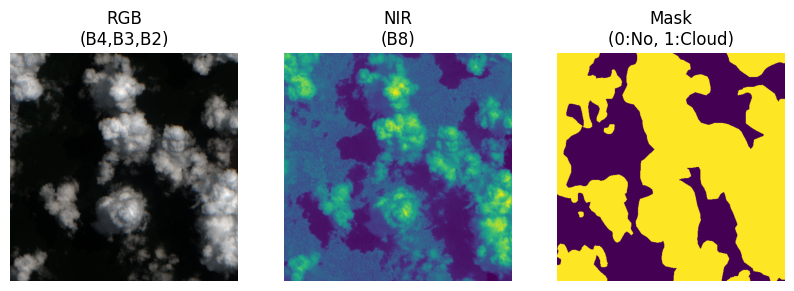

In [13]:
idxs = np.random.randint(0, len(train_dataset)-1, 1)

for i, idx in enumerate(idxs):
    print(train_dataset.metadata.loc[idx,'chip_id'])
    train_dataset.plot(train_dataset[idx])

zrtj


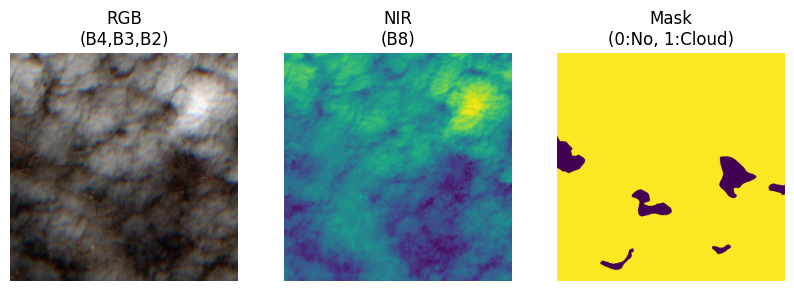

In [14]:
idxs = np.random.randint(0, len(test_dataset)-1, 1)

for i, idx in enumerate(idxs):
    print(test_dataset.metadata.loc[idx,'chip_id'])
    test_dataset.plot(test_dataset[idx])

In [15]:
from terratorch.datamodules import TorchNonGeoDataModule
from torchgeo.datamodules import NonGeoDataModule
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_datamodule = TorchNonGeoDataModule(

    # Dataset Module
    cls = NonGeoDataModule,
    batch_size = 4,
    num_workers = 0,

    # Dataset
    dataset_class = CustomCloudCoverDetection,
    root = './',
    split = 'train',
    transforms=[A.Normalize(normalization='min_max_per_channel'), # Rescale value 0 ~ 1 by each band
                ToTensorV2()],
    download=False
)

test_datamodule = TorchNonGeoDataModule(

    # Dataset Module
    cls = NonGeoDataModule,
    batch_size = 4,
    num_workers = 0,

    # Dataset
    dataset_class = CustomCloudCoverDetection,
    root = './',
    split = 'test',
    transforms=[A.Normalize(normalization='min_max_per_channel'), # Rescale value 0 ~ 1 by each band
                ToTensorV2()],
    download=False
)

# Lightning Trainers

How to set validation set?

In [16]:
from terratorch.tasks import SemanticSegmentationTask

model_args = {
        "backbone":"resnet50", # see smp_encoders.keys()
        'model': 'Unet', # 'DeepLabV3', 'DeepLabV3Plus', 'FPN', 'Linknet', 'MAnet', 'PAN', 'PSPNet', 'Unet', 'UnetPlusPlus'
        "bands": bands,
        "in_channels": 4,
        "num_classes": 2,
        "pretrained": True,
}

task = SemanticSegmentationTask(
    model_args=model_args,
    model_factory="SMPModelFactory",
    loss="dice",
    lr=1e-4,
    ignore_index=-1,
    optimizer="AdamW",
    optimizer_hparams={"weight_decay": 0.05},
    freeze_backbone=True,
    class_names=['No', 'Cloud'],
    # class_weights=[0.1, 0.9]
)

In [17]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint, RichProgressBar
from lightning.pytorch.loggers import TensorBoardLogger

checkpoint_callback = ModelCheckpoint(monitor=task.monitor, save_top_k=1, save_last=True)
early_stopping_callback = EarlyStopping(monitor=task.monitor, min_delta=0.00, patience=20)
logger = TensorBoardLogger(save_dir='output', name='tutorial')

trainer = Trainer(
    devices=1, # Number of GPUs. Interactive mode recommended with 1 device
    precision="16-mixed",
    callbacks=[
        RichProgressBar(),
        checkpoint_callback,
        early_stopping_callback,
        LearningRateMonitor(logging_interval="epoch"),
    ],
    logger=logger,
    max_epochs=1, # train only one epoch for demo
    default_root_dir='output/tutorial',
    log_every_n_steps=1,
    check_val_every_n_epoch=1
)
_ = trainer.fit(model=task, datamodule=train_datamodule)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


TypeError: library.dataset.CustomCloudCoverDetection() got multiple values for keyword argument 'split'

In [ ]:
res = trainer.test(model=task, datamodule=test_datamodule)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃              Test metric               ┃              DataLoader 0              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/Multiclass_Accuracy        │           0.9042260646820068           │
│        test/Multiclass_F1_Score        │           0.9042260646820068           │
│     test/Multiclass_Jaccard_Index      │           0.6812360286712646           │
│  test/Multiclass_Jaccard_Index_Micro   │           0.8251940011978149           │
│               test/loss                │          0.28467822074890137           │
│     test/multiclassaccuracy_Burned     │           0.906612753868103            │
│   test/multiclassaccuracy_Not burned   │           0.9039826393127441           │
│   test/multiclassjaccardindex_Burned   │          0.46701979637145996           │
│ test/multiclassjaccardindex_Not burned │           0.8954523205757141           │
└────────────────────────────────────────┴────────────────────────────────────────┘

In [ ]:
# Analyze training in tensorboard
!tensorboard --logdir output/ --port 9010  # add --host $(hostname -f) for clusters

TensorFlow installation not found - running with reduced feature set.
TensorBoard 2.17.1 at http://Thornhill:9010/ (Press CTRL+C to quit)
^C


# CLI tool

You find an example for SMP models in `configs/burnscars_smp.yaml` that you can run with `terratorch fit -c configs/burnscars_smp.yaml`.